# DQN

# Import the Libraries

In [1]:
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from PortfolioRebalancerEnv import PortfolioRebalancerEnv

# Create Replay Memory Class

In [2]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Create Q-Network

In [3]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 32)
        self.layer2 = nn.Linear(32, 32)
        self.layer3 = nn.Linear(32, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

# Get Data

In [4]:
df = pd.read_csv("data/Data.csv", index_col=0)
df = df.apply(pd.to_numeric)
returns_df = df.pct_change()[1:]
returns_df.head()

,Close_A,Close_B
Date,,
3/1/13,-0.009699,0.011927
4/1/13,0.005072,-0.004811
7/1/13,-0.004350,-0.000445
8/1/13,-0.005592,-0.000840
9/1/13,0.005097,0.008598


In [5]:
pd.date_range(returns_df.index[-1], returns_df.index[0], freq='m')

DatetimeIndex([], dtype='datetime64[ns]', freq='M')

In [6]:
returns_df.cov()

,Close_A,Close_B
Close_A,0.000076,-0.000003
Close_B,-0.000003,0.000122


# Calculate mean variance optimal portfolio

In [7]:
def get_min_var_portfolio(ret_df,
                          wA,
                          detail):
    # Straight from : https://github.com/costantinontario/Optimal-Rebalancing-Strategy-using-Dynamic-Programming/blob/master/DP_Project.py
    # with a few changes

    #Calculate Covariance Matrix
    Covariance_Matrix = ret_df.cov()

    # Create DataFrame
    index = np.arange(1 / detail)
    columns = ['WeightA', 'Variance']
    A = pd.DataFrame(columns=columns, index = index)

    # Optimal_WeightA = 0

    # Create for loop to calculate the Efficient Frontier Utility and identify its minimum along with respective weight where this occurs
    for i in range(0, int(1 / detail)):
        A['WeightA'][i] = wA
        weights = np.array([wA, 1-wA])
        A['Variance'][i] = np.dot(weights.T, np.dot(Covariance_Matrix, weights))

        # Calculate minimum Efficient Frontier Function value along with respective weight
        try:
            # Check if next point Variance is lower than previous one (if it is keep the weight at which this occurs)
            if A['Variance'][i] < A['Variance'][i-1]:
                Optimal_WeightA = A['WeightA'][i]
        except:
            pass

        # Increase weight by increment previously specified
        wA = wA + detail

    # Print the calculated Optimal Portfolio Weight
    print('Optimal Portfolio Weight According to Efficient Frontier Using Mean-Variance Optimization: ' + str(Optimal_WeightA))
    return Optimal_WeightA, A


In [8]:
# Allocate Initial weight factor and precision
wA=0.0

# Define detail of weight increments
detail = 0.0005

In [9]:
Optimal_WeightA, A = get_min_var_portfolio(ret_df=returns_df,
                      wA=wA,
                      detail=detail)

Optimal Portfolio Weight According to Efficient Frontier Using Mean-Variance Optimization: 0.6144999999999877


In [10]:
optimal_var = A[A['WeightA'] == Optimal_WeightA]['Variance'].values[0]
optimal_var

4.5060460288452534e-05

<AxesSubplot:>

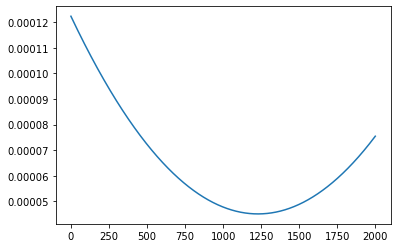

In [11]:
A['Variance'].plot()

# TODO: Need to find a way to show when rebalancing occured
# TODO: need to account to change in stock prices to see how investment changes to see if rebalancing occurs

In [12]:
def get_portfolio_stats(ret_df, var_df, idx_loc):
    """
    Calculate mean and variance of portfolio at each time step? Might change later

    :param ret_df:
    :return:
    """
    # TODO: This needs to be fixed
    # TODO: get total returns from min variance optimization above (need to add)
    # TODO: then fix current variance like below using matrix algebra
    # TODO: Then fix costs (utility stuff)
    # TODO: Add threshold of rebalancing
    # TODO: Add total run time
    Cost_Min['Variance_Current'][line2] = ((Cost_Min['Returns_A'][line2]-Cost_Min['Total_Returns'][line2])**2)* \
                                                (Cost_Min['WeightA'][line2]**2) + ((Cost_Min['Returns_B'][line2]-Cost_Min['Total_Returns'][line2])**2)* \
                                                ((1-Cost_Min['WeightA'][line2])**2) + 2*(1-Cost_Min['WeightA'][line2])*Cost_Min['WeightA'][line2]*Covariance_Matrix[1,0]

    # calculates mean up to given point in time
    current_mean = ret_df.iloc[:idx_loc, :].mean().mean()

    # same for var
    current_var = var_df.iloc[idx_loc, 1] # 1 is variance and 0 is weight (for the column index)
    return current_mean, current_var

# Create GYM Environment

In [13]:
mu = returns_df.iloc[0].mean()
sigma_optimal = optimal_var
sigma_current = A['Variance'][0]
# w_optimal = np.array([Optimal_WeightA, 1-Optimal_WeightA])
w_optimal = Optimal_WeightA
initial_amount_invested = 1000000000
transaction_costs = np.array([60, 40])
n_assets = 2
action_range_min = -0.07
action_range_max = 0.07
num_actions = 15
w_min = 0.2
w_max= 0.8

In [14]:
env = PortfolioRebalancerEnv(
    mu=mu,
    sigma_optimal=sigma_optimal,
    sigma_current=sigma_current,
    w_optimal=w_optimal,
    initial_amount_invested=initial_amount_invested,
    transaction_costs=transaction_costs,
    n_assets=n_assets,
    action_range_min=action_range_min,
    action_range_max=action_range_max,
    num_actions=num_actions,
    w_min=w_min,
    w_max=w_max
)

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cpu")

TypeError: __init__() got an unexpected keyword argument 'sigma_optimal'

# Training

RL:
- BATCH_SIZE is the number of transitions sampled from the replay buffer
- GAMMA is the discount factor as mentioned in the previous section
- EPS_START is the starting value of epsilon
- EPS_END is the final value of epsilon
- EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
- TAU is the update rate of the target network
- LR is the learning rate of the AdamW optimizer

Finance:
- $\mu$ is historical mean returns for each asset
- $\Sigma$ is the historical covariance of returns

In [15]:
# RL:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

In [16]:
# Get number of actions from gym action space
n_actions = env.num_actions
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0

NameError: name 'env' is not defined

In [15]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            print(policy_net(state))
            print(policy_net(state).max())
            print(policy_net(state).max(1))
            print(policy_net(state).max(1)[1])
            print(policy_net(state).max(1)[1].view(1, 1))
            optimal_action_index = policy_net(state).max(1)[1].view(1, 1)
            return torch.tensor([[env.action_space[optimal_action_index]]], device=device, dtype=torch.float)
    else:
        return torch.tensor([[np.random.choice(env.action_space)]], device=device, dtype=torch.float)

In [16]:
episode_durations = []

def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 20 episode averages and plot them too
    if len(durations_t) >= 20:
        means = durations_t.unfold(0, 20, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(19), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [17]:
def plot_weights(weights, show_result=False):
    plt.figure(1)
    w_t = torch.tensor(weights, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Day')
    plt.ylabel('Weight in Asset A')
    plt.plot(w_t.numpy())
    # Take 20 episode averages and plot them too
    if len(w_t) >= 20:
        means = w_t.unfold(0, 20, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(19), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [18]:
# transitions = memory.sample(BATCH_SIZE)
# # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
# # detailed explanation). This converts batch-array of Transitions
# # to Transition of batch-arrays.
# batch = Transition(*zip(*transitions))
#
# # Compute a mask of non-final states and concatenate the batch elements
# # (a final state would've been the one after which simulation ended)
# non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
#                                         batch.next_state)), device=device, dtype=torch.bool)
# non_final_next_states = torch.cat([s for s in batch.next_state
#                                    if s is not None])
# state_batch = torch.cat(batch.state)
# action_batch = torch.cat(batch.action)
# reward_batch = torch.cat(batch.reward)

In [19]:
# def convert_action_to_index(action_value):
#     return np.where(np.array(env.action_space) == torch.tensor(action_value, device=device, dtype=torch.float32)[0])[0]


def convert_action_to_index(action_value):
    t = np.argsort(env.action_space)
    output = t[np.searchsorted(env.action_space, action_value, sorter=t)]
    return output

In [20]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                       if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # int_act_batch = torch.tensor(np.array(list(map(convert_action_to_index, action_batch))), device=device, dtype=torch.int32)
    int_act_batch = action_batch.apply_(convert_action_to_index).to(torch.int64)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, int_act_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

# Run Training

In [26]:
current_mean, current_var = get_portfolio_stats(ret_df=returns_df, var_df=A, idx_loc=1)
env.sigma_current = current_var
env.mu = current_mean

In [85]:
state, info = env.reset()
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

In [86]:
state

tensor([[0.4188]])

In [87]:
action = select_action(state)
action

tensor([[-0.0200]])

In [88]:
observation, reward, done = env.step(action.item())

In [89]:
observation[0]

0.39883664

In [90]:
reward = torch.tensor([reward], device=device, dtype=torch.float32)

In [91]:
reward

tensor([-2.2566e+10])

In [92]:
next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
next_state

tensor([[0.3988]])

In [93]:
memory.push(state, action, next_state, reward)
state = next_state
optimize_model()

In [99]:
memory.sample(3)

[Transition(state=tensor([[0.5944]]), action=tensor([[0.0600]]), next_state=tensor([[0.6544]]), reward=tensor([-4.9863e+09])),
 Transition(state=tensor([[0.5324]]), action=tensor([[-0.0100]]), next_state=tensor([[0.5224]]), reward=tensor([-1.0213e+10])),
 Transition(state=tensor([[0.4188]]), action=tensor([[-0.0200]]), next_state=tensor([[0.3988]]), reward=tensor([-2.2566e+10]))]

In [21]:
# if torch.cuda.is_available():
#     num_episodes = 600
# else:
#     num_episodes = 50

num_episodes = 1000

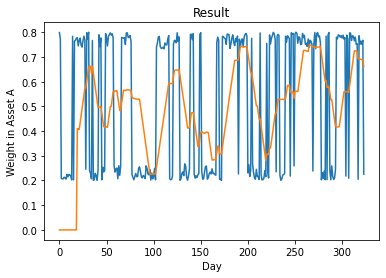

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [73]:
w_A_dict = dict()
weightA_array = []
total_cost_array = []
# TODO: Change num episodes to be in loop and loop outside based on each row in dataframe of data
for i in range(1, len(returns_df)):
    w_A_dict[i] = []

    # update mean and variance at each time step
    current_mean, current_var = get_portfolio_stats(ret_df=returns_df, var_df=A, idx_loc=i)
    env.sigma_current = current_var
    env.mu = current_mean

    for i_episode in range(num_episodes):
        # Initialize the environment and get it's state
        state, info = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        w_A_dict[i].append(state.squeeze().clone().detach())

        action = select_action(state)
        observation, reward, done = env.step(action.item())
        reward = torch.tensor([reward], device=device, dtype=torch.float32)

        if done:
            next_state = None
            # store variables for plotting
            weightA_array.append(state.squeeze().clone().detach())
            total_cost_array.append(-reward.squeeze().clone().detach())
        else:
            # get new state
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)



        if done:
            # episode_durations.append(t + 1)
            plot_weights(weights=weightA_array)
            break

    # print('Complete')
    # TODO: Plot weights over time
    # TODO: show when rebalancing occured
    plot_weights(weights=weightA_array, show_result=True)
    plt.ioff()
    plt.show()

# Analysis

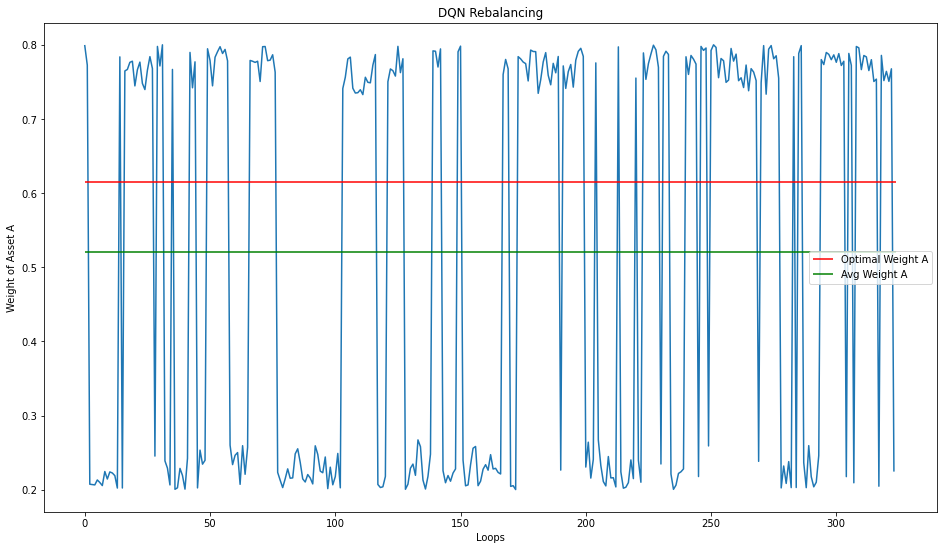

In [74]:
plt.figure(figsize=(16, 9))
plt.title("DQN Rebalancing")
plt.ylabel("Weight of Asset A")
plt.xlabel("Loops")
plt.plot(weightA_array)
plt.hlines(w_optimal, 0, len(weightA_array), color = 'r', label='Optimal Weight A')
plt.hlines(np.mean(weightA_array), 0, len(weightA_array), color = 'g', label='Avg Weight A')
plt.legend()
plt.show()

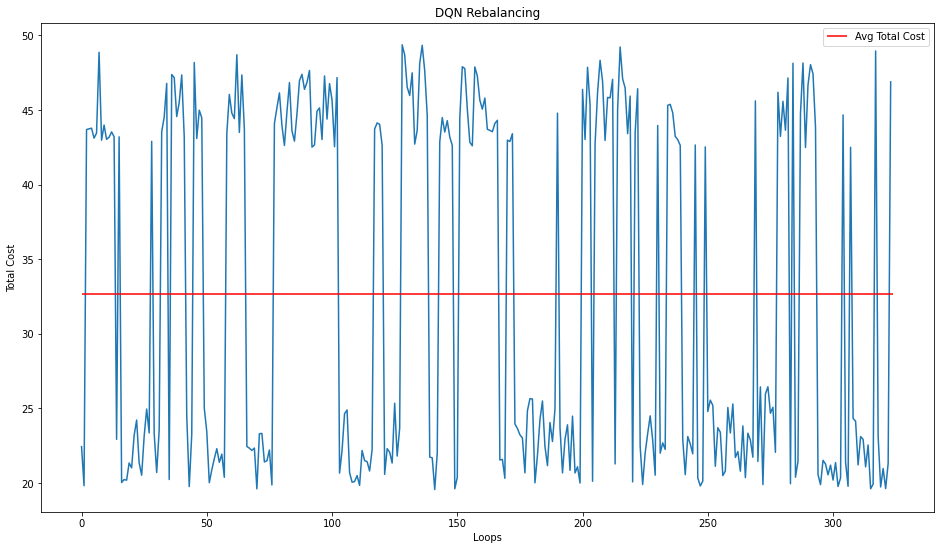

In [75]:
plt.figure(figsize=(16, 9))
plt.title("DQN Rebalancing")
plt.ylabel("Total Cost")
plt.xlabel("Loops")
plt.plot(total_cost_array)
plt.hlines(np.mean(total_cost_array), 0, len(total_cost_array), color = 'r', label='Avg Total Cost')
plt.legend()
plt.show()

In [76]:
np.mean(total_cost_array)

32.642735